# **1. Análisis Exploratorio de los Datos**

## **1.1 Carga de librerías, datos y verificación de su estado.**

En esta sección realizaremos el cargue de los datos a analizar y de las librerías que nos ayudarán a hacer esto posible.

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import statsmodels
import os

from scipy.sparse import hstack, csr_matrix
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Antes de empezar, procederemos a hacer algunos ajustes que nos ayudarán a la hora de visualizar más adelante. Junto a ello, cargaremos los datos y funciones que ayudarán a desarrollar esta exploración.

In [ ]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [ ]:
def analizar_dataframe(df, nombre="DataFrame"):
    from IPython.display import display
    
    print(f"\n Análisis exploratorio de: {nombre}")
    print("=" * 75)
    
    print(f"Filas: {df.shape[0]:,}  |  Columnas: {df.shape[1]}")
    print("=" * 75)
    
    print(df.dtypes)
    print("=" * 75)
    
    display(df.head())
    

In [ ]:
analizar_dataframe(df, nombre="WA_Fn-UseC_-Telco-Customer-Churn.csv")


 Análisis exploratorio de: WA_Fn-UseC_-Telco-Customer-Churn.csv
Filas: 7,043  |  Columnas: 21
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Este dataset relacionado con *churn* tiene un total de 7,043 filas o registros, teniendo cada unas 20 columnas o variables, dando aproximadamente 140.000 observaciones, con la mayoría de variables teniendo la característica de objeto o caracteres, y solo teniendo pocas de valor numérico.

Podemos destacar que la variable **MonthlyCharges**, a pesar de tener valores numéricos, está considerada como object. Junto a esto, la variable **SeniorCitizen** está escrita como valores binarios. Por el desarrollo del análisis, vamos a cambiar los valores y el tipo de variable a continuación.

In [ ]:
def convertir_binaria_a_si_no(df, columnas):
    df_copy = df.copy()
    for col in columnas:
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].map({0: "No", 1: "Yes"}).astype("object")
    return df_copy

df = convertir_binaria_a_si_no(df, ["SeniorCitizen"])

In [ ]:
def convertir_columna_a_float(df, columna):
    df_copy = df.copy()
    if columna in df_copy.columns:
        if not pd.api.types.is_numeric_dtype(df_copy[columna]):
            df_copy[columna] = (
                df_copy[columna]
                .astype(str)
                .str.replace(r"[^0-9\.-]", "", regex=True)  
                .replace("", "0")  
                .astype(float)
            )
    return df_copy


df = convertir_columna_a_float(df, "MonthlyCharges")
df = convertir_columna_a_float(df, "TotalCharges")

In [ ]:
df.dtypes.value_counts()

object     18
float64     2
int64       1
Name: count, dtype: int64

Con estos cambios, podemos corroborar la información si volvemos a ver el resumen de los datos.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## **1.2 Verificación de datos faltantes y outliers.**

A continuación, usaremos un mapa de calor para observar si existen datos faltantes dentro de nuestro dataset.

In [ ]:
def mostrar_faltantes(df):
    faltantes = df.isnull().sum()
    porcentaje = (faltantes / len(df)) * 100

    tabla_faltantes = pd.DataFrame({
        'Valores faltantes': faltantes,
        'Porcentaje (%)': porcentaje
    })

    tabla_faltantes = tabla_faltantes[tabla_faltantes['Valores faltantes'] > 0]
    tabla_faltantes.sort_values('Porcentaje (%)', ascending=False)
    return tabla_faltantes

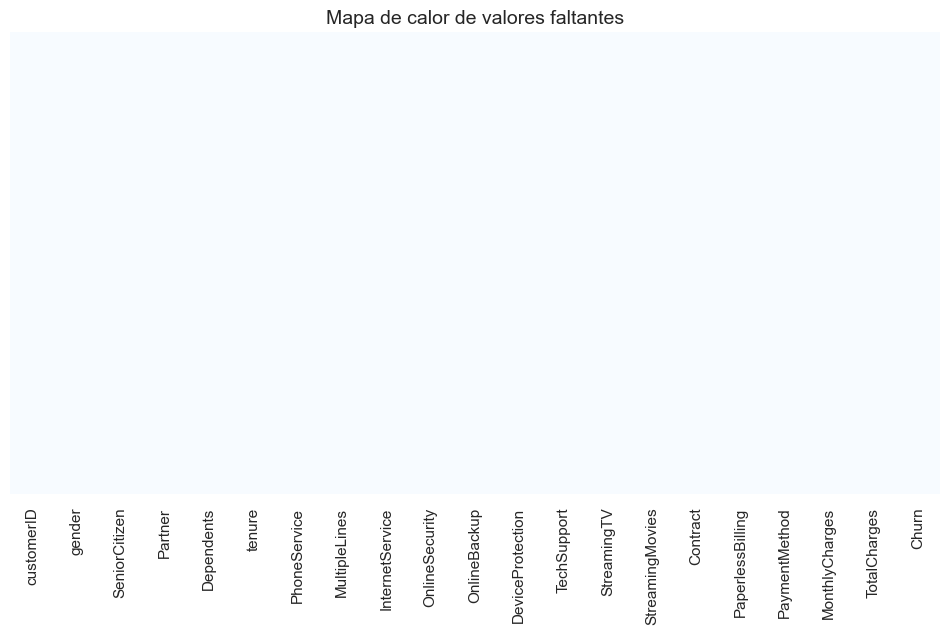

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='Blues')
plt.title("Mapa de calor de valores faltantes", fontsize=14)
plt.show()

Afortunadamente, en este caso, no vemos presencia de datos faltantes; esto lo podemos corroborar viendo los porcentajes de faltantes para cada variable en forma tabular.

In [ ]:
mostrar_faltantes(df)

,Valores faltantes,Porcentaje (%)


Junto a lo anterior, verifiquemos si existen problemas con registros duplicados.

In [ ]:
duplicados_totales = df.duplicated().sum()
print("Duplicados totales en el dataset:", duplicados_totales)

df[df.duplicated(keep=False)].head()

Duplicados totales en el dataset: 0


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


Al parecer, tampoco hay registros duplicados en este dataset. Finalmente, veamos los datos atípicos que tenemos para nuestras variables numéricas.

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns

print(num_cols)

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


In [ ]:
outlier_summary = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)][col]
    outlier_summary[col] = len(outliers)

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['n_outliers'])
outlier_df['porcentaje'] = 100 * outlier_df['n_outliers'] / len(df)
outlier_df.sort_values('porcentaje', ascending=False)

,n_outliers,porcentaje
tenure,0,0.0
MonthlyCharges,0,0.0
TotalCharges,0,0.0


Como se puede observar, no existen prevalencias de datos faltantes, duplicados o atípicos. Esto lo hará más eficaz a la hora de observar el análisis debido a su estado.

## **1.3 Verificación de correlación y multicolinealidad.**

A continuación, observemos si en los datos hay índices de multicolinealidad. Para esto, haremos un mapa de calor, y posteriormente se hará el cálculo del VIF para tener constancia de estos resultados.

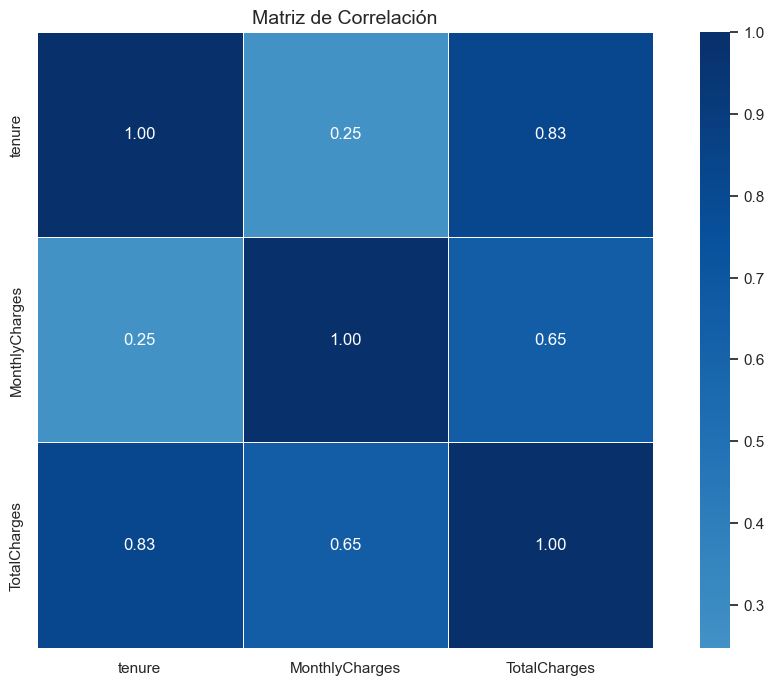

In [ ]:
num_vars = df.select_dtypes(include=["int64", "float64"])
corr_matrix = num_vars.corr()

plt.figure(figsize=(12,8))
sns.heatmap(
    corr_matrix,
    cmap="Blues",
    center=0,
    annot=True,        
    fmt=".2f",         
    linewidths=0.5,    
    square=True
)
plt.title("Matriz de Correlación", fontsize=14)
plt.show()

Aquí, la variable **TotalCharges** o costo total tiene un índice de correlación de 0.83, lo que indica que hay una correlación entre esta variable y otras. Observemos su comportamiento calculando el VIF.

In [ ]:
df_num = num_vars.dropna()

X = add_constant(df_num)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]


pd.set_option("display.max_rows", None)  
print(vif_data) 

         Variable        VIF
0           const  14.899868
1          tenure   5.836728
2  MonthlyCharges   3.216730
3    TotalCharges   9.510931


Nos damos cuenta de que el VIF para **TotalCharges** es de casi 10, por lo que sospechamos un alto índice de multicolinealidad en esta variable. Esto tendría sentido, ya que podríamos establecer que el costo total (**TotalCharges**) es el producto entre el total de meses y el costo mensual. Para esto, hagamos una nueva columna que tenga este producto en cuenta.

In [ ]:
df["es_multiplo"] = np.isclose(df["TotalCharges"], df["tenure"] * df["MonthlyCharges"], atol=1)
print(df["es_multiplo"].value_counts(dropna=False))


es_multiplo
False    6289
True      754
Name: count, dtype: int64


Gracias a lo anterior, vemos que casi el $10%$ de los datos se pueden expresar como combinación lineal, claro, este valor puede variar, pero se observa una dependencia lineal entre las columnas **MonthlyCharges** y **tenure**, con esto en mente, vamos a descartarla de nuestro dataset y recalculamos el VIF para observar los cambios que hemos tenido.

In [ ]:
df.drop(["TotalCharges","es_multiplo"], axis=1, inplace=True, errors="ignore")

In [ ]:
num_vars = df.select_dtypes(include=["int64", "float64"])
df_num = num_vars.dropna()

X = add_constant(df_num)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]


pd.set_option("display.max_rows", None)  
print(vif_data) 

         Variable       VIF
0           const  6.288768
1          tenure  1.065478
2  MonthlyCharges  1.065478


Con este cálculo hecho, vemos cómo el VIF ha disminuido drásticamente (casi por debajo de 1), con valores muy bajos en comparación de antes. Ahora, usemos la V de Cramer para ver si hay multicolinealidad entre variables categorías.

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cat_vars = df.select_dtypes(include=["object"]).columns

assoc_matrix = pd.DataFrame(
    np.zeros((len(cat_vars), len(cat_vars))),
    index=cat_vars,
    columns=cat_vars
)

for col1 in cat_vars:
    for col2 in cat_vars:
        if col1 != col2:
            assoc_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

print(assoc_matrix.round(3))

C:\Users\taran\AppData\Local\Temp\ipykernel_19592\2173232291.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\taran\AppData\Local\Temp\ipykernel_19592\2173232291.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\taran\AppData\Local\Temp\ipykernel_19592\2173232291.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\taran\AppData\Local\Temp\ipykernel_19592\2173232291.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\taran\AppData\Local\Temp\ipykernel_19592\2173232291.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\taran\AppData\Local\Temp\ipykernel_19592\2173232291.py:10: RuntimeWarning: inv

                  customerID  gender  SeniorCitizen  Partner  Dependents  \
customerID               0.0     inf            inf      NaN         inf   
gender                   NaN   0.000          0.000    0.000       0.000   
SeniorCitizen            inf   0.000          0.000    0.011       0.210   
Partner                  inf   0.000          0.011    0.000       0.452   
Dependents               inf   0.000          0.210    0.452       0.000   
PhoneService             NaN   0.000          0.000    0.012       0.000   
MultipleLines            NaN   0.000          0.146    0.143       0.019   
InternetService          NaN   0.000          0.265    0.000       0.179   
OnlineSecurity           inf   0.002          0.210    0.151       0.194   
OnlineBackup             inf   0.000          0.182    0.152       0.162   
DeviceProtection         inf   0.000          0.182    0.166       0.157   
TechSupport              NaN   0.000          0.223    0.127       0.182   
StreamingTV 

C:\Users\taran\AppData\Local\Temp\ipykernel_19592\2173232291.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


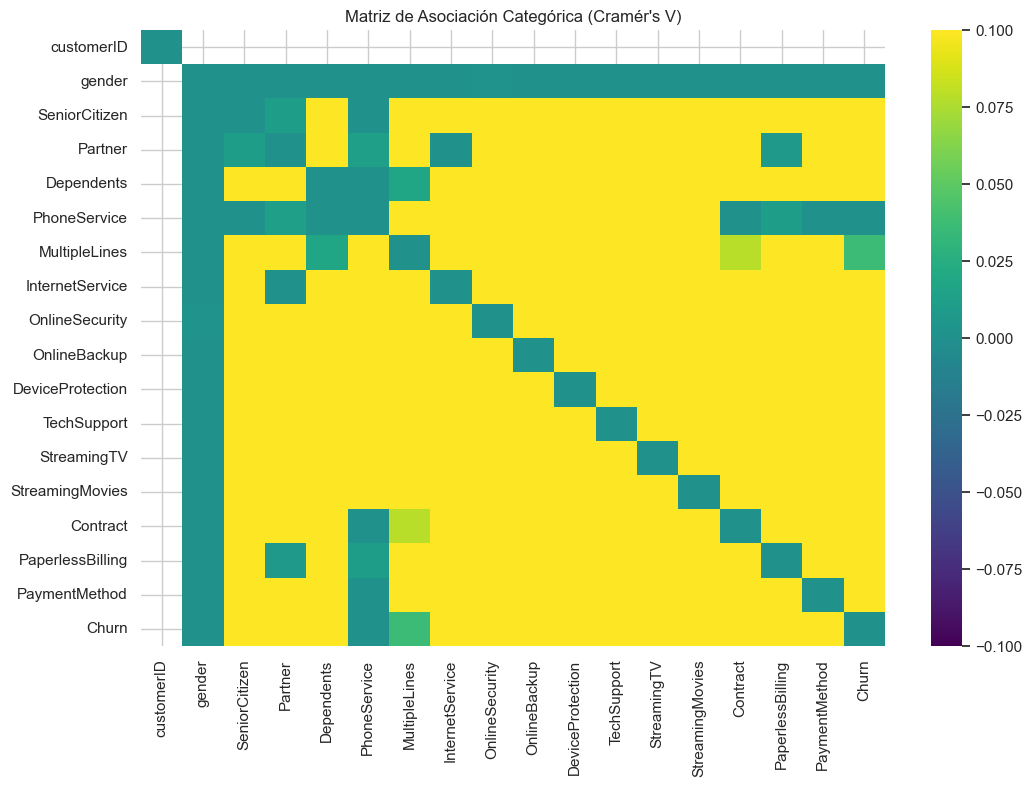

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(assoc_matrix, cmap="viridis", annot=False)
plt.title("Matriz de Asociación Categórica (Cramér's V)")
plt.show()

De esta matriz de asociación de variables categoricas, vemos que, en su gran mayoría, su relación no presenta problemas de multicolinealidad, con valores oscilando entre el 0.1 y el -0.025. Con esto en mente, también podremos eliminar la variable **customerID** al ser este un indicador único, que no aporta información tanto al análisis o al modelo posterior.

In [ ]:
df.drop(["customerID"], axis=1, inplace=True, errors="ignore")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes


## **1.4 Análisis Exploratorio.**

### **1.4.0 Previo al análisis**

Ahora, por temas de sencillez a la hora de analizar, renombraremos las variables a formas más sencillas:

In [ ]:
df.rename(columns={
    "SeniorCitizen": "senior",
    "Partner": "partner",
    "Dependents": "dependents",        
    "PhoneService": "phone",
    "MultipleLines": "phone_multiple",
    "InternetService": "internet",
    "OnlineSecurity": "internet_security",
    "OnlineBackup": "internet_backup",
    "DeviceProtection": "internet_protection",
    "TechSupport": "internet_support",
    "StreamingTV": "streaming_tv",
    "StreamingMovies": "streaming_movies",
    "Contract": "contract",
    "PaperlessBilling": "paperless",
    "PaymentMethod": "payment",
    "MonthlyCharges": "charges_monthly",
    "Churn": "churn",
}, inplace=True)


En este caso, nuestra variable de interés es **churn**, la cual indica si un usuario abandonó o no. Veamos la proporción antes de ver el análisis.

In [ ]:
df["churn"] = df["churn"].map({"Yes": 1, "No": 0})
print(df["churn"].value_counts(dropna=False))


churn
0    5174
1    1869
Name: count, dtype: int64


La variable **churn** presenta un desbalance, con 5174 registros de 0 y 1869 registros de 1. En este contexto, el 0 significa que el usuario no abandonó, mientras que 1 implica que el usuario abandonó.

In [ ]:
df.to_csv("data_churn_EDA.csv", index=False)

### **1.4.1 Análisis para variables categoricas.**

En primera vista, veamos cómo la variable objetivo se comporta junto a otras variables categoricas.

C:\Users\taran\AppData\Local\Temp\ipykernel_19592\2665910966.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='churn', palette='Blues_r')


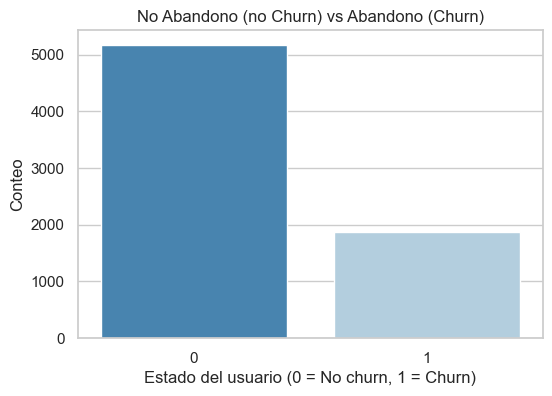

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='churn', palette='Blues_r')
plt.title("No Abandono (no Churn) vs Abandono (Churn)")
plt.ylabel("Conteo") 
plt.xlabel("Estado del usuario (0 = No churn, 1 = Churn)")
plt.show()

Este gráfico de barras representa la misma proporción vista en la sección anterior, donde existe un desbalance entre ambos usuarios.

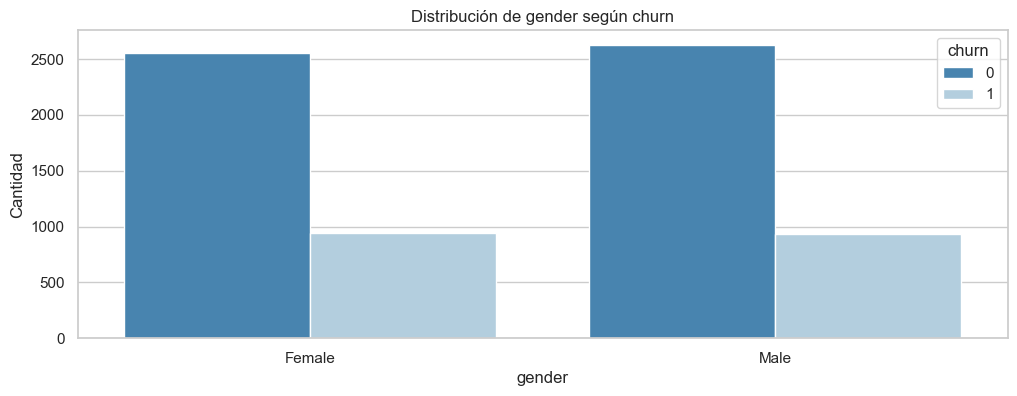

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(data=df, x="gender", hue="churn", palette="Blues_r")
plt.title("Distribución de gender según churn")
plt.xlabel("gender")
plt.ylabel("Cantidad")
plt.show()

Si observamos la distribución de género y los usuarios que hicieron churn y no churn, vemos que la distribución es muy similar de ambos lados, es decir, de los usuarios que abandonaron y no abandonaron. Podemos destacar que ligeramente hay más usuarios hombres que mujeres dentro del dataset.

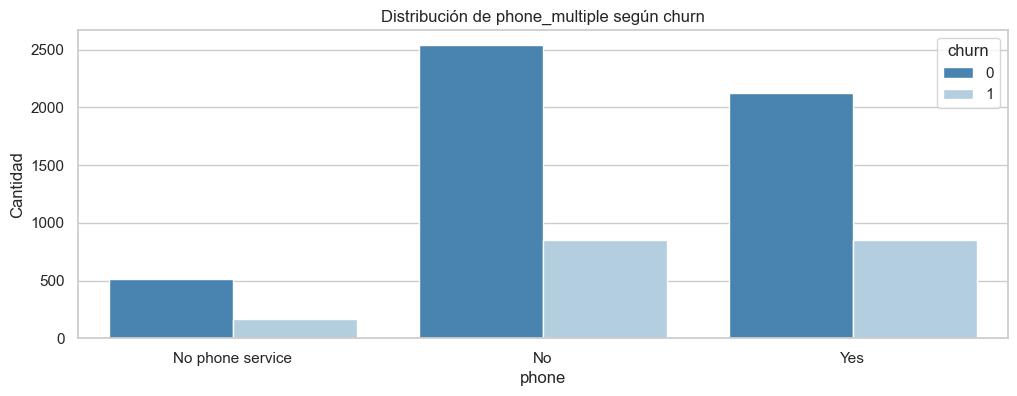

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(data=df, x="phone_multiple", hue="churn", palette="Blues_r")
plt.title("Distribución de phone_multiple según churn")
plt.xlabel("phone")
plt.ylabel("Cantidad")
plt.show()

Aquí tenemos la variable **phone_multiple**, lo que indica si un usuario tiene más de una línea telefónica activa. Dentro de estos resultados, vemos que la mayoría de los usuarios en las diferentes categorías no han abandonado, con la gran proporción de estos en la sección de "No", es decir, que solo tienen una línea telefónica. Curiosamente, parece que es más común tener más de una línea activa a no tener líneas de teléfono activas.

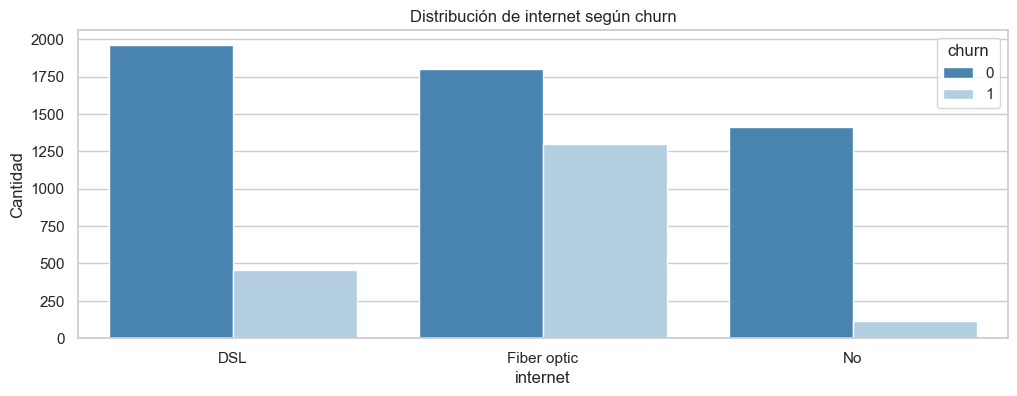

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(data=df, x="internet", hue="churn", palette="Blues_r")
plt.title("Distribución de internet según churn")
plt.xlabel("internet")
plt.ylabel("Cantidad")
plt.show()

Para la variable **Internet*, observamos un comportamiento diferente a lo anterior visto. Empecemos con que existe una gran proporción de usuarios que no tienen redes de internet, pero aquellos que sí se dividen en dos grandes categorías: DSL y "Fiber optic". De estos, los usuarios que tienen "Fiber optic" tienen mayor prevalencia a abandonar que aquellos de DSL. Este resultado podría darnos indicios sobre aquellas variables que más afecten a la hora de modelar.

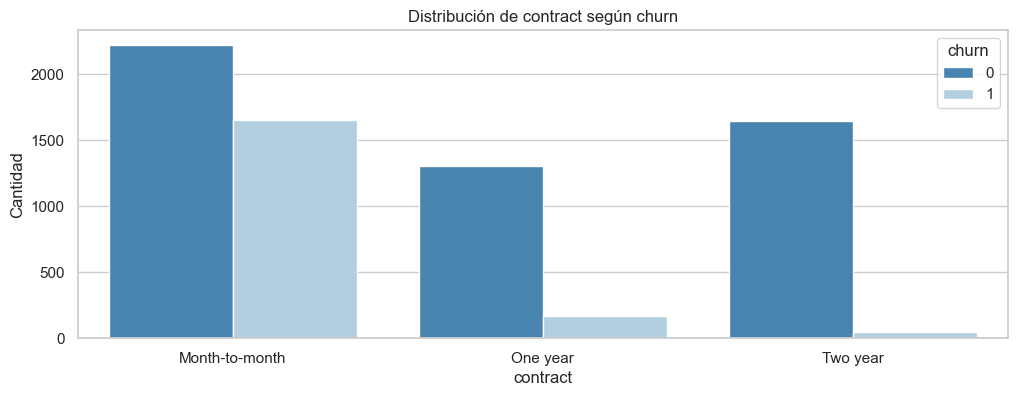

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(data=df, x="contract", hue="churn", palette="Blues_r")
plt.title("Distribución de contract según churn")
plt.xlabel("contract")
plt.ylabel("Cantidad")
plt.show()

Si observamos ahora la variable **contract**, que indica el tipo de contrato que tienen los usuarios, vemos tres categorías: Month-to-month, One year y Two Year. Los usuarios que tengan contratos de un año o más tienen muy baja tendencia a hacer churn, mientras que aquellos usuarios que tengan de mes a mes si son más propensos a abandonar.

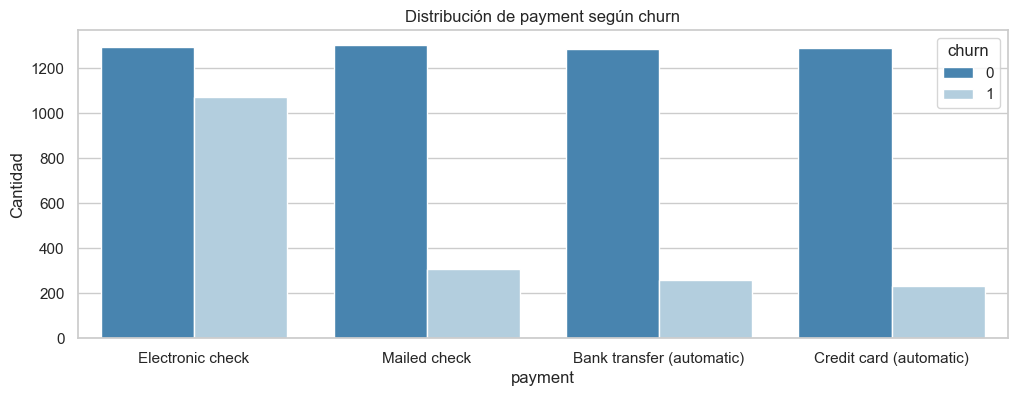

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(data=df, x="payment", hue="churn", palette="Blues_r")
plt.title("Distribución de payment según churn")
plt.xlabel("payment")
plt.ylabel("Cantidad")
plt.show()

Finalmente, para los métodos de pago observamos una tendencia en relación con aquellos usuarios que son más propensos a abandonar: aquellos usuarios que reciban un cheque electrónico, a casi la misma proporción de aquellos que no abandonan, también suelen abandonar. Sin embargo, para el resto de métodos de pago, los usuarios mantienen una tasa baja de abandono.

### **1.4.2 Análisis para variables numericas.**

Ahora, haremos de forma análoga, pero con las variables numéricas.

C:\Users\taran\AppData\Local\Temp\ipykernel_19592\3033057271.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="churn", y="tenure", palette="Blues_r", ax=axes[0])


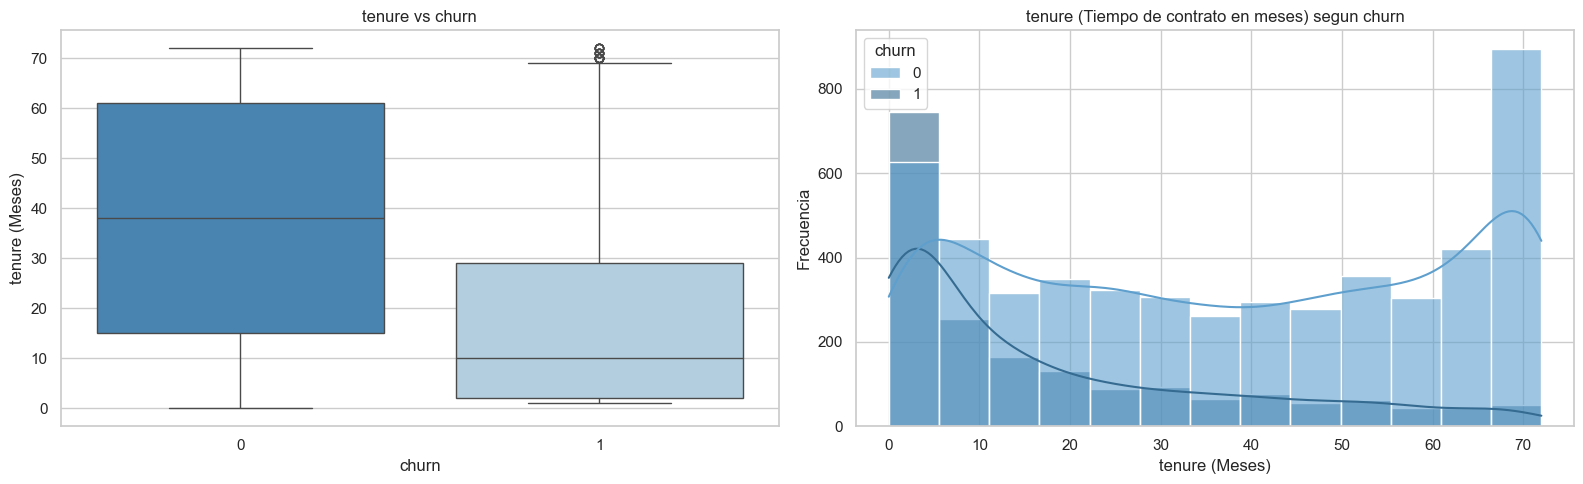

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

sns.boxplot(data=df, x="churn", y="tenure", palette="Blues_r", ax=axes[0])
axes[0].set_title("tenure vs churn")
axes[0].set_ylabel("tenure (Meses)")

sns.histplot(data=df, x="tenure", hue="churn", palette="Blues_d", bins=13, kde=True, alpha=0.6, ax=axes[1])
axes[1].set_title("tenure (Tiempo de contrato en meses) segun churn")
axes[1].set_xlabel("tenure (Meses)")
axes[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

Para la variable **tenure**, se observa que el comportamiento de los usuarios que abandonan parece seguir una tendencia. Aquellos usuarios que abandonan suelen tener poco tiempo con la empresa, de 0 a 10 meses, mientras que aquellos que no abandonan tienen un rango bastante amplio, de 10 a un máximo de 70 meses, siendo este intervalo superior a la moda para estos usuarios.

C:\Users\taran\AppData\Local\Temp\ipykernel_19592\82208992.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="churn", y="charges_monthly", palette="Blues_r", ax=axes[0])


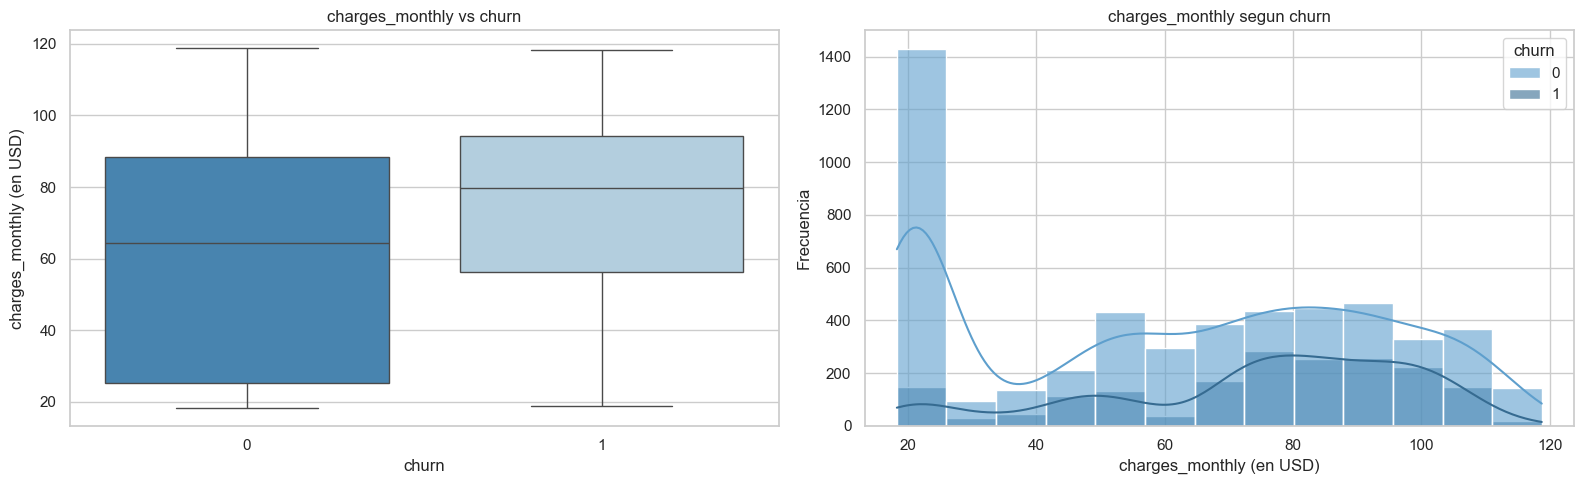

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

sns.boxplot(data=df, x="churn", y="charges_monthly", palette="Blues_r", ax=axes[0])
axes[0].set_title("charges_monthly vs churn")
axes[0].set_ylabel("charges_monthly (en USD)")

sns.histplot(data=df, x="charges_monthly", hue="churn", palette="Blues_d", bins=13, kde=True, alpha=0.6, ax=axes[1])
axes[1].set_title("charges_monthly segun churn")
axes[1].set_xlabel("charges_monthly (en USD)")
axes[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

Para esta variable, **charges_monthly**, el costo mensual para ambos usuarios es casi constante. No existe un patrón o tendencia a seguir, con ambos usuarios teniendo costos similares, siendo los usuarios que no abandonan que tienen mayor variabilidad en costos. Cabe resaltar que ambos grupos poseen el mismo rango mínimo y máximo para los costos.

Con esto en mente, podemos tener esto en cuenta y lo mismo que los resúmenes anteriores para usarlo como estrategias para el modelado, que se hará a continuación.